<a href="https://colab.research.google.com/github/sat2567/CNN/blob/main/X_ray_detectionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT PACKAGES

In [ ]:
import tensorflow as tf
from tensorflow import keras
import torch
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.io

import math
import sklearn
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import random
from IPython.display import HTML


In [ ]:
from keras.applications.resnet import ResNet50
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

# MOUNT FROM DRIVE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Creating Custom Dataset

In [ ]:
class_names = ['Brain','Brain_tumor', 'NORMAL',"PNEUMONIA","Tuberculosis"]
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if (x.lower().endswith('jpeg') or x.lower().endswith('png') or x.lower().endswith('jpg'))]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Brain','Brain_tumor', 'NORMAL',"PNEUMONIA","Tuberculosis"] 
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

## Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Prepare dataloader

In [ ]:
root_dir="/content/drive/MyDrive/chest-xray-pneumonia/chest_xray"
root_test_dir="/content/drive/MyDrive/chest-xray-pneumonia/Test"

In [ ]:
import os

train_dirs = {
    'Brain': f'{root_dir}/Brain',
    'Brain_tumor': f'{root_dir}/Brain_tumor',
    'NORMAL': f'{root_dir}/NORMAL',
    'PNEUMONIA': f'{root_dir}/PNEUMONIA',
    'Tuberculosis': f'{root_dir}/Tuberculosis'
}


In [ ]:
import os

test_dirs = {
    'Brain': f'{root_dir}/Brain',
    'Brain_tumor': f'{root_test_dir}/Brain_tumor',
    'NORMAL': f'{root_test_dir}/NORMAL',
    'PNEUMONIA': f'{root_test_dir}/PNEUMONIA',
    'Tuberculosis': f'{root_test_dir}/Tuberculosis'
}


In [ ]:


train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 88 Brain examples
Found 141 Brain_tumor examples
Found 219 NORMAL examples
Found 375 PNEUMONIA examples
Found 675 Tuberculosis examples


In [ ]:
test_dataset=ChestXRayDataset(test_dirs, test_transform)

Found 88 Brain examples
Found 14 Brain_tumor examples
Found 15 NORMAL examples
Found 15 PNEUMONIA examples
Found 27 Tuberculosis examples


In [ ]:
batch_size = 8

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Data Visualization

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(16, 16))
    for i, image in enumerate(images):
        plt.subplot(1, 8, i+1)#, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

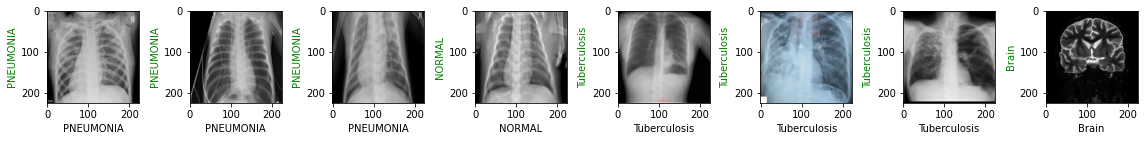

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

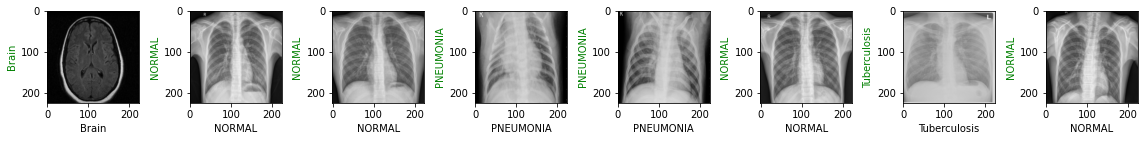

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## Creating Model Architecture

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=5)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

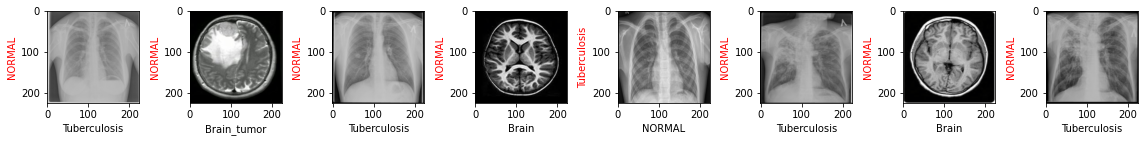

In [ ]:

show_preds()

## Training the model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy>= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.8342, Accuracy: 0.1195


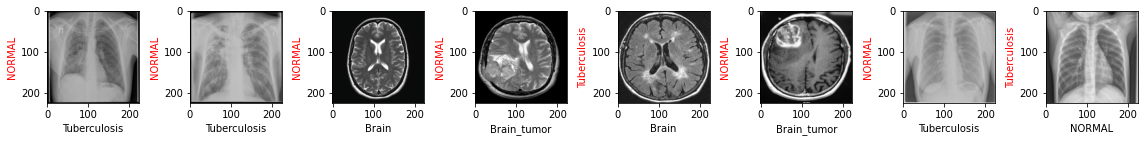

Evaluating at step 20
Validation Loss: 0.8419, Accuracy: 0.6730


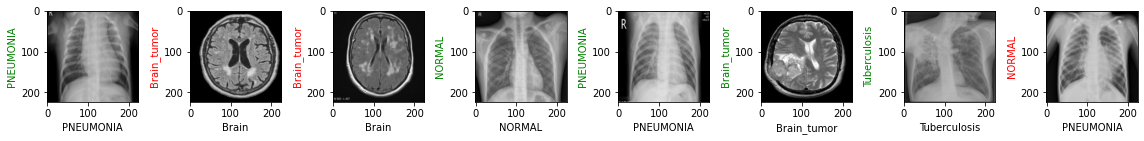

Evaluating at step 40
Validation Loss: 0.4469, Accuracy: 0.8553


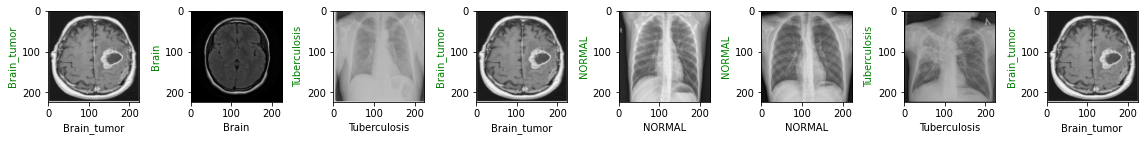

Evaluating at step 60
Validation Loss: 0.2632, Accuracy: 0.9245


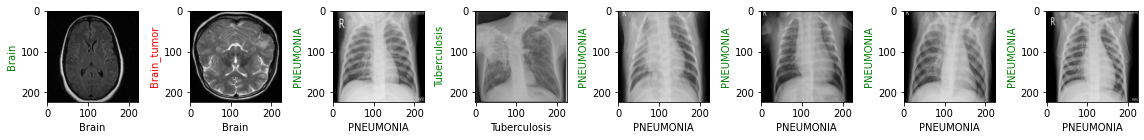

Evaluating at step 80
Validation Loss: 0.1872, Accuracy: 0.9560


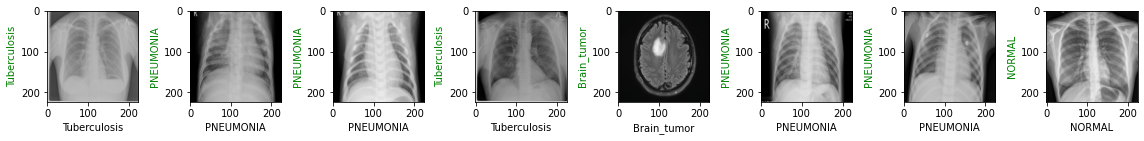

Evaluating at step 100
Validation Loss: 0.1779, Accuracy: 0.9560


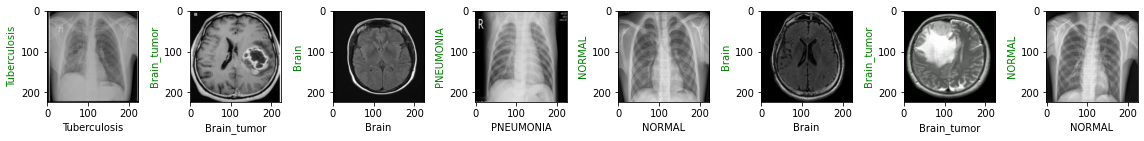

Evaluating at step 120
Validation Loss: 0.1729, Accuracy: 0.9371


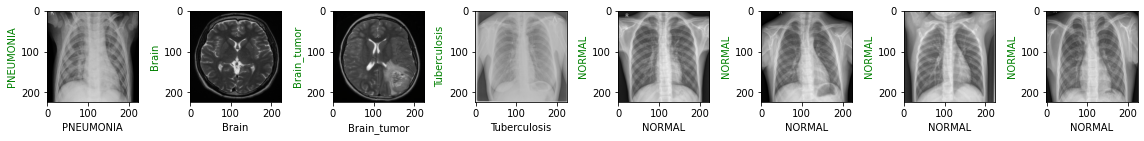

Evaluating at step 140
Validation Loss: 0.1635, Accuracy: 0.9245


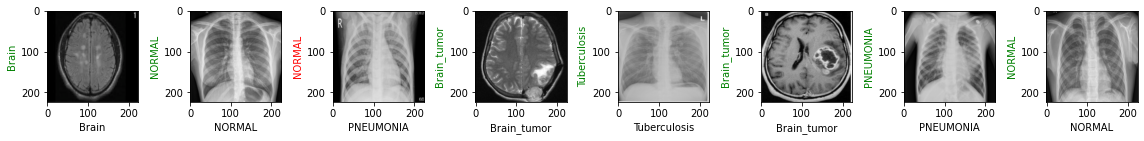

Evaluating at step 160
Validation Loss: 0.1055, Accuracy: 0.9811


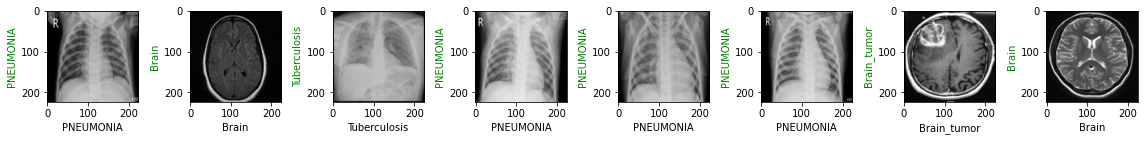

Performance condition satisfied, stopping..


In [ ]:
train(epochs=1)


## Show the prediction

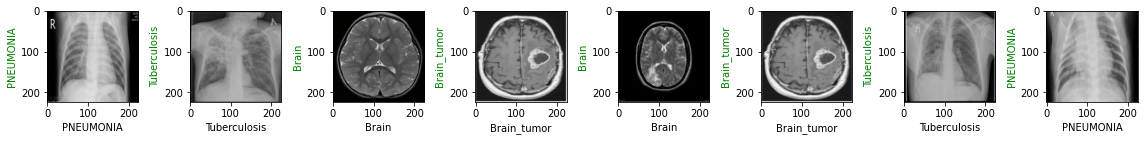

In [ ]:
show_preds()

## Save the Model

In [ ]:
torch.save(resnet18.state_dict(), 'disease_classifier.pt')

In [ ]:
# Load the model and set in eval
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=5)

resnet18.load_state_dict(torch.load('/content/drive/MyDrive/disease_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    im=Image.open(image_path)
    
    return probabilities, predicted_class_index, predicted_class_name

## Test on new Image[link text](https://)

In [ ]:
image_path = 'satya.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)


Probabilities: [0.0607984  0.03885451 0.0662608  0.02600879 0.8080775 ]
Predicted class index: 4
Predicted class name: Tuberculosis


In [ ]:
any(probabilities)>0.90

True